### Import des librairies

In [24]:
import pandas as pd
import numpy as np
import os
from IPython.display import Image, display

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import ensemble
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Lecture des CSV avec panda

In [15]:
dataframes = {
    "country": pd.read_csv('exported_data/country.csv'),
    "disease": pd.read_csv('exported_data/disease.csv'),
    "location": pd.read_csv('exported_data/location.csv'),
    "region": pd.read_csv('exported_data/region.csv'),
    "disease_case": pd.read_csv('exported_data/disease_case.csv'),
}
print("Les fichiers CSV ont été chargés avec succès.\n")
for name, df in dataframes.items():
    print(f"--- {name}.csv ---")
    display(df.head(5))

Les fichiers CSV ont été chargés avec succès.

--- country.csv ---


,id,continent,name,population,who_region
0,252,OCEANIA,Papua New Guinea,8963009.0,Western_Pacific
1,253,ASIA,Cambodia,16741375.0,Western_Pacific
2,254,ASIA,Kazakhstan,18798667.0,Europe
3,255,SOUTH_AMERICA,Paraguay,7141091.0,Americas
4,256,ASIA,Syria,17539600.0,Eastern_Mediterranean


--- disease.csv ---


,id,description,name
0,2,NaN,COVID-19


--- location.csv ---


,id,name,region_id
0,3652,Netherlands - region standard - location standard,482
1,3653,Falkland Islands - region standard - location ...,557
2,3654,Slovenia - region standard - location standard,438
3,3655,Macao - region standard - location standard,492
4,3656,Tunisia - region standard - location standard,500


--- region.csv ---


,id,name,country_id
0,352,Curaçao - region standard,369
1,353,Comoros - region standard,273
2,354,Dominica - region standard,347
3,355,Latvia - region standard,356
4,356,Grenada - region standard,353


--- disease_case.csv ---


,id,confirmed_case,date,deaths,recovered,disease_id,location_id
0,711052,0,2020-01-22,0,0,2,3692
1,711053,0,2020-01-22,0,0,2,3837
2,711054,0,2020-01-22,0,0,2,3836
3,711055,0,2020-01-22,0,0,2,3750
4,711056,0,2020-01-22,0,0,2,3819


### Fusion des fichiers CSV

In [16]:
# Fusion des fichiers
country_df = dataframes["country"]
disease_df = dataframes["disease"]
location_df = dataframes["location"]
region_df = dataframes["region"]
disease_case_df = dataframes["disease_case"]

region_country_df = pd.merge(region_df, country_df, left_on='country_id', right_on='id', suffixes=('_region', '_country'))
location_region_country_df = pd.merge(location_df, region_country_df, left_on='region_id', right_on='id_region')
full_df = pd.merge(disease_case_df, location_region_country_df, left_on='location_id', right_on='id')
full_df = pd.merge(full_df, disease_df[['id', 'name']], left_on='disease_id', right_on='id', how='left', suffixes=('', '_disease'))
display(full_df.head())
print("Colonnes disponibles :", list(full_df.columns))

,id_x,confirmed_case,date,deaths,recovered,disease_id,location_id,id_y,name,region_id,id_region,name_region,country_id,id_country,continent,name_country,population,who_region,id,name_disease
0,711052,0,2020-01-22,0,0,2,3692,3692,Afghanistan - region standard - location standard,443,443,Afghanistan - region standard,329,329,ASIA,Afghanistan,39009447.0,Eastern_Mediterranean,2,COVID-19
1,711053,0,2020-01-22,0,0,2,3837,3837,Albania - region standard - location standard,427,427,Albania - region standard,425,425,EUROPE,Albania,2877470.0,Europe,2,COVID-19
2,711054,0,2020-01-22,0,0,2,3836,3836,Algeria - region standard - location standard,386,386,Algeria - region standard,318,318,AFRICA,Algeria,43926079.0,Africa,2,COVID-19
3,711055,0,2020-01-22,0,0,2,3750,3750,Andorra - region standard - location standard,395,395,Andorra - region standard,285,285,EUROPE,Andorra,77278.0,Europe,2,COVID-19
4,711056,0,2020-01-22,0,0,2,3819,3819,Angola - region standard - location standard,529,529,Angola - region standard,349,349,AFRICA,Angola,32956300.0,Africa,2,COVID-19


Colonnes disponibles : ['id_x', 'confirmed_case', 'date', 'deaths', 'recovered', 'disease_id', 'location_id', 'id_y', 'name', 'region_id', 'id_region', 'name_region', 'country_id', 'id_country', 'continent', 'name_country', 'population', 'who_region', 'id', 'name_disease']


### Suppression des colonnes de clés étrangères et rennomage des colonnes floues

In [17]:
foreign_keys = ['disease_id', 'location_id', 'region_id', 'country_id', 'id_x', 'id_y', 'id_region', 'id_country', 'id']
full_df_cleaned = full_df.drop(columns=[col for col in foreign_keys if col in full_df.columns])
full_df_cleaned = full_df_cleaned.rename(columns={
    'name': 'location',
    'name_region': 'region',
    'name_country': 'country',
    'name_disease': 'disease'
})
display(full_df_cleaned.head())
print("Colonnes disponibles :", list(full_df_cleaned.columns))

,confirmed_case,date,deaths,recovered,location,region,continent,country,population,who_region,disease
0,0,2020-01-22,0,0,Afghanistan - region standard - location standard,Afghanistan - region standard,ASIA,Afghanistan,39009447.0,Eastern_Mediterranean,COVID-19
1,0,2020-01-22,0,0,Albania - region standard - location standard,Albania - region standard,EUROPE,Albania,2877470.0,Europe,COVID-19
2,0,2020-01-22,0,0,Algeria - region standard - location standard,Algeria - region standard,AFRICA,Algeria,43926079.0,Africa,COVID-19
3,0,2020-01-22,0,0,Andorra - region standard - location standard,Andorra - region standard,EUROPE,Andorra,77278.0,Europe,COVID-19
4,0,2020-01-22,0,0,Angola - region standard - location standard,Angola - region standard,AFRICA,Angola,32956300.0,Africa,COVID-19


Colonnes disponibles : ['confirmed_case', 'date', 'deaths', 'recovered', 'location', 'region', 'continent', 'country', 'population', 'who_region', 'disease']


### Creer 4 jeux de données : train features et labels (70%) et dev features et labels (30%).

In [53]:
# On enlève la colonne 'date' et la colonne cible de la liste des features
encoded_df = pd.get_dummies(full_df_cleaned.drop(columns=['date']), drop_first=True)

# Définir la cible et les features
labels = encoded_df['confirmed_case']
features = encoded_df.drop(columns=['confirmed_case'])

# Diviser les données en train/dev (70% - 30%)
X_train, X_dev, y_train, y_dev = train_test_split(features, labels, test_size=0.5, random_state=42)

print(f"Features d'entraînement (X_train) : {X_train.shape}")
print(f"Labels d'entraînement (y_train) : {y_train.shape}")
print(f"Features de développement (X_dev) : {X_dev.shape}")
print(f"Labels de développement (y_dev) : {y_dev.shape}")

Features d'entraînement (X_train) : (42112, 727)
Labels d'entraînement (y_train) : (42112,)
Features de développement (X_dev) : (42112, 727)
Labels de développement (y_dev) : (42112,)


### Réalisation d'un algorithme de Random Forest sur les données

In [54]:
# Instanciation du modèle Random Forest avec 10 arbres et une profondeur maximale de 6
random_forest = RandomForestClassifier(n_estimators=10, max_depth=6, random_state=42)

# Entraînement du modèle sur les données d'entraînement
random_forest.fit(X_train, y_train)

# Calcul de la précision sur le jeu de développement
accuracy = random_forest.score(X_dev, y_dev)
print(f'Précision du modèle Random Forest sur le jeu de développement : {accuracy}')

Précision du modèle Random Forest sur le jeu de développement : 0.2396466565349544


### Sélection aléatoire de 3 arbres dans la forêt

In [57]:
import random

# Sélection aléatoire de 3 arbres dans la forêt
arbres_aleatoires = random.sample(random_forest.estimators_, 3)

# Afficher les informations de base sur chaque arbre sélectionné
for i, arbre in enumerate(arbres_aleatoires, start=1):
    print(f"Arbre aléatoire {i}:")
    print(f" - Nombre de nœuds : {arbre.tree_.node_count}")
    print(f" - Profondeur : {arbre.tree_.max_depth}")
    print()


Arbre aléatoire 1:
 - Nombre de nœuds : 23
 - Profondeur : 6

Arbre aléatoire 2:
 - Nombre de nœuds : 45
 - Profondeur : 6

Arbre aléatoire 3:
 - Nombre de nœuds : 39
 - Profondeur : 6



### Affichage de l'arbre obtenu en utilisant graphwiz

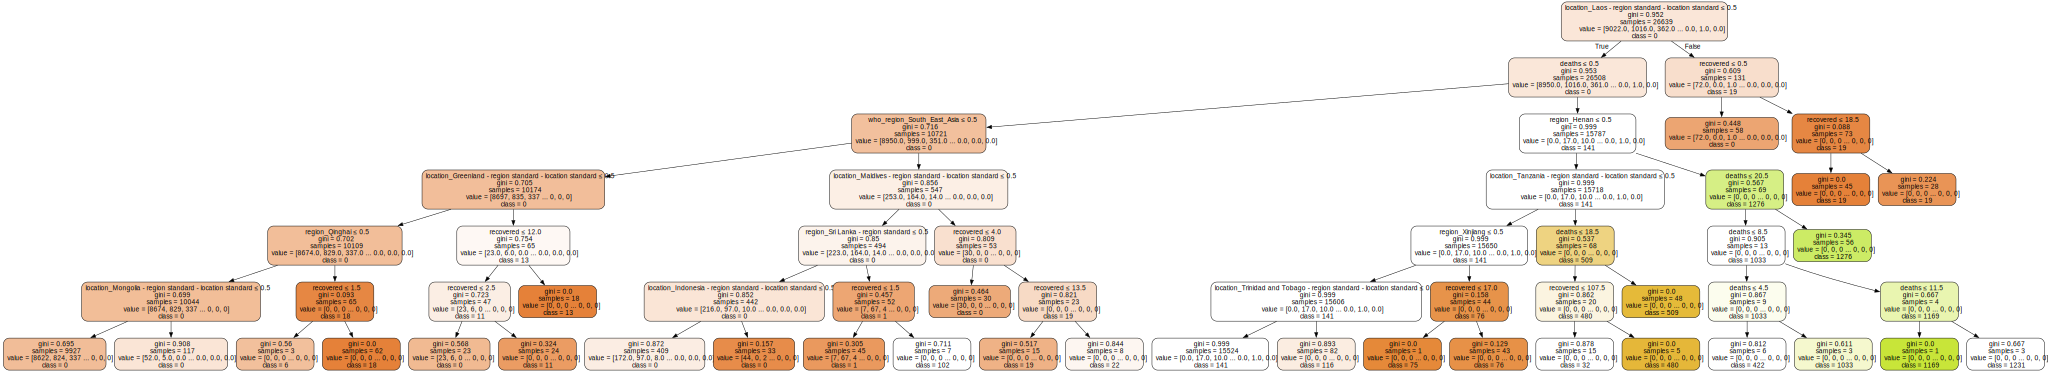

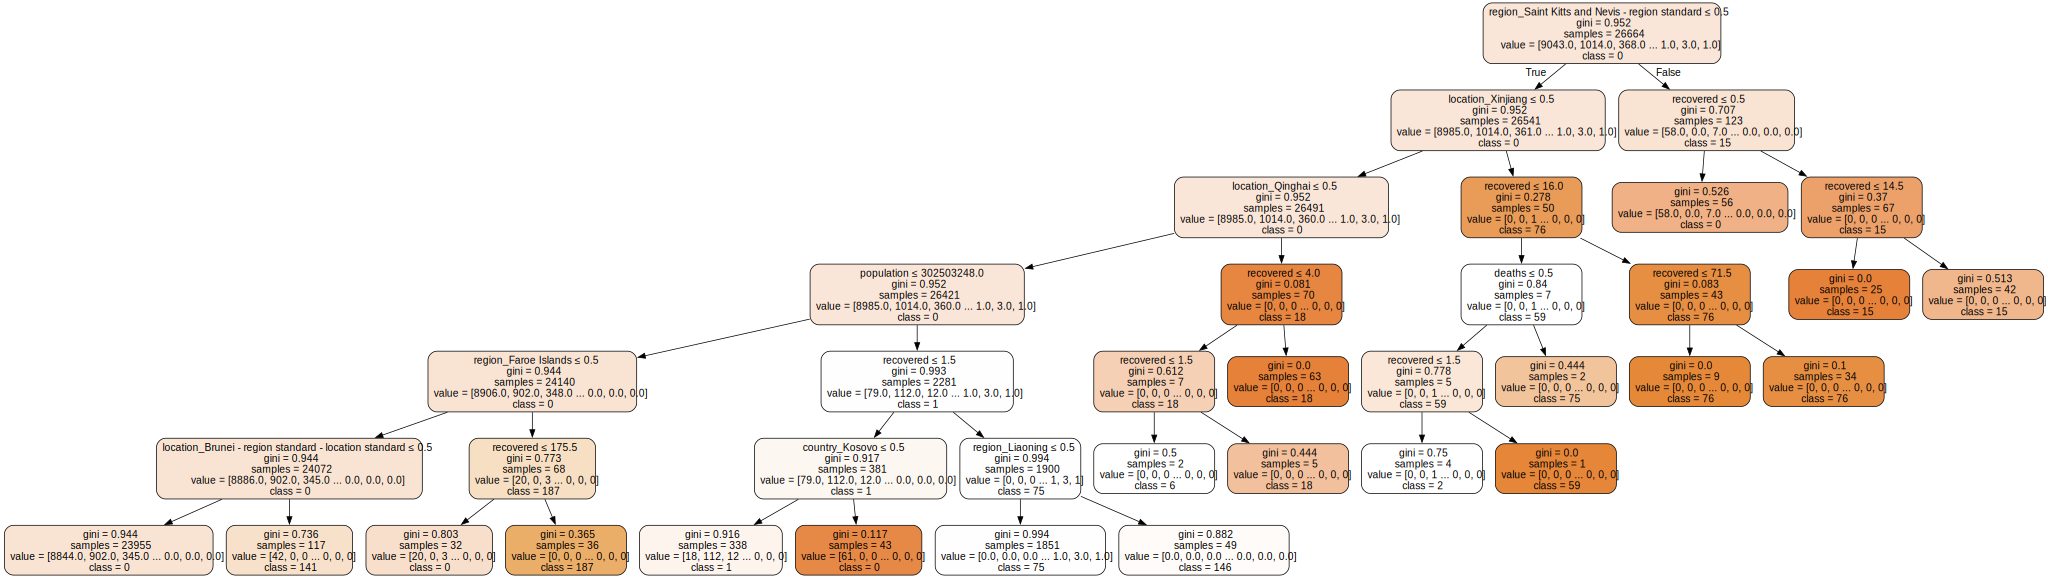

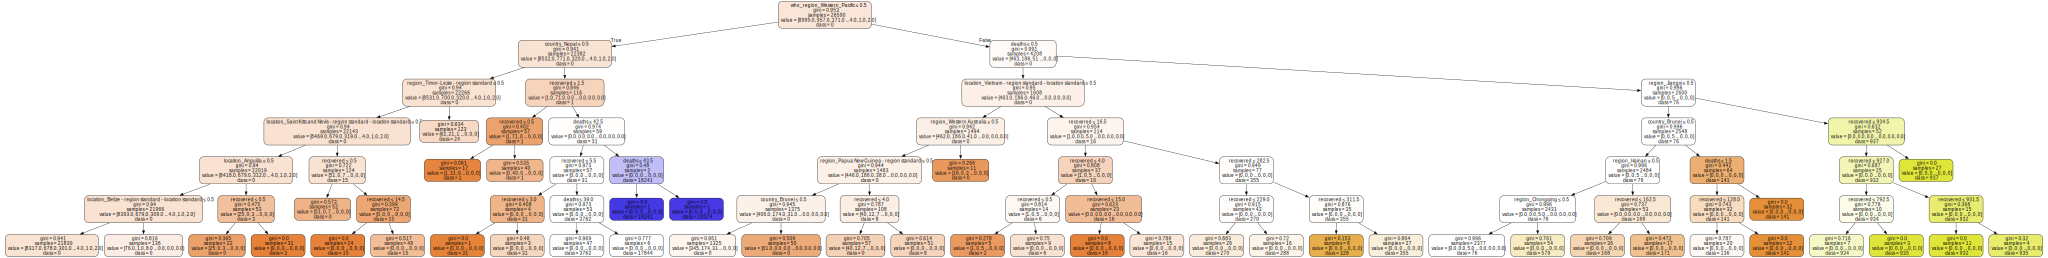

In [58]:

# Extraire l'arbre
arbre = random_forest.estimators_[0]

# Générer dynamiquement les classes
class_names = [str(c) for c in sorted(y_train.unique())]

# Exporter le DOT
dot_data = export_graphviz(
    arbre,
    out_file=None,
    feature_names=features.columns,
    class_names=class_names,
    filled=True,
    rounded=True,
    special_characters=True
)

for i in range(3):
    arbre = random_forest.estimators_[i]
    dot_data = export_graphviz(
        arbre,
        out_file=None,
        feature_names=features.columns,
        class_names=[str(c) for c in sorted(y_train.unique())],
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    display(graph)

In [59]:
# Calcul de la précision sur le jeu de développement
accuracy = random_forest.score(X_dev, y_dev)
print(f'Précision du modèle Random Forest sur le jeu de développement : {accuracy:.2f}')


Précision du modèle Random Forest sur le jeu de développement : 0.24


In [60]:
import joblib

# Sauvegarder le modèle Random Forest entraîné
joblib.dump(random_forest, "random_forest_model.pkl")

['random_forest_model.pkl']